In [1]:
from os import scandir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = 'l/'

files = [file.name for file in scandir(data) if ".csv" in file.name]
files

['eval_last_th0.05.csv', 'train_last_th0.05.csv']

In [3]:
def process_data(filename):
    try:
        
        session_info = filename[:-4].split('_')
        data_kept = str(1-float(session_info[2][2:]))
        df = pd.read_csv(f'{data}{filename}', header=None)
        df.columns = [f'{session_info[0]}-1', f'{session_info[0]}-{data_kept}']
        df[f'{df.columns[0]}_Correct'] = df[df.columns[0]] > .5
        df[f'{df.columns[1]}_Correct'] = df[df.columns[1]] > .5
        df[f'{df.columns[1]}_LessCorrect'] = df[df.columns[0]] > df[df.columns[1]]
        df[f'{df.columns[1]}_ResultChange'] = (df[f'{df.columns[0]}_Correct'] != df[f'{df.columns[1]}_Correct'])
        
    except IndexError:
        print(filename)
    
    return df

In [4]:
processed = {filename[:-4]:process_data(filename) for filename in files}

In [5]:
data_files = {}

for filename, data in processed.items():
    session_info = filename.split('_')
    file_index = f'{session_info[0]}_{session_info[1]}'
    
    if file_index in data_files:
        data = data.drop([data.columns[0],data.columns[2]], axis=1)
        data_files[file_index] = pd.concat([data_files[file_index], data], axis=1)
    else:
        data_files[file_index] = data

In [6]:
def format_for_figures(df, match='_Correct'):
    cols = [col for col in df.columns if match in col]
    df = df[cols]
    df.columns = [col.split('-')[1].split("_")[0] for col in df.columns]
    results = df.sum()/df.shape[0]
    
    return results

In [7]:
data = {key:format_for_figures(data_files[key]) for key in data_files.keys()}

graph_df = pd.concat(data,axis=0, ignore_index=False).reset_index()
graph_df.columns = ['Experiment', 'Percent_Kept', 'Accuracy']
graph_df['Percent_Kept'] = pd.to_numeric(graph_df['Percent_Kept']) * 100
graph_df['Data'] = graph_df['Experiment'].apply(lambda s:s.split('_')[0])
graph_df['Filter_Layer'] = graph_df['Experiment'].apply(lambda s:s.split('_')[1])
graph_df = graph_df.drop('Experiment', axis=1)
graph_df.columns

Index(['Percent_Kept', 'Accuracy', 'Data', 'Filter_Layer'], dtype='object')

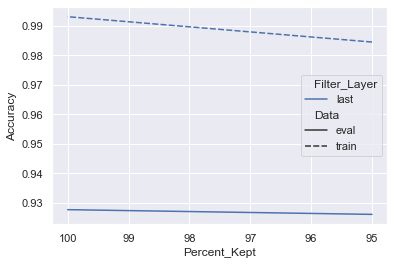

In [8]:
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
ax = sns.lineplot(x="Percent_Kept", y="Accuracy",
             hue="Filter_Layer", style="Data",
             data=graph_df)

ax.invert_xaxis()
plt.savefig('results.svg')

In [11]:
graph_df.to_csv("output.csv", index=False)